### Table of Contents

* [I/ Data insight](#data-insight)
* [II/ Feature extraction](#feature-extraction)
    * [A) Color extraction](#color-extraction)
        * [1 - Creating a color palette](#color-palette)
        * [2 - Extracting color features using our palette](#extract)
    * [B) Shape extraction](#shape-extraction)
        * [1 - Hu moments](#hu-moments)
        * [2 - ORB](#orb)
* [III/ Model creation](#model-creation)
    * [A) Classifier used](#classifier-used)
    * [A) Reasons Behind Selection](#reason)
* [IV/ Model creation](#model-evaluation)
    * [A) Dummy classifier](#dummy-classifier)
    * [B) Train Color descriptor (alone)](#color-descriptor)
    * [C) Train Shape descriptor](#shape-descriptor)
        * [1 - Hu moments (alone)](#hu-moment-alone)
        * [2 - ORB (alone)](#orb-alone)
    * [D) Train color descriptor + Shape descriptor (Hu moment)](#combined)
        * [1 - Early fusion](#early)
        * [2 - Late fusion](#late)
* [V/ Model benchmark](#model-benchmark)
    * [A) Benchmark](#benchmark)
    * [B) Interpretation](#interpretation)

# I/ Data insight <a class="anchor" id="data-insight"></a>

In [1]:
from app.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

RANDOM_SEED = 40

np.random.seed(RANDOM_SEED)

Before delving directly into modeling, it is good practice to take a look at the data we are dealing with.

In [2]:
dataset, labels = load_dataset("./dataset/train")

label_to_category = {}
with open("./dataset/labels.txt", "r") as f:
    for line in f.readlines():
        if line != "\n":
            label, category = line.split(":")
            label_to_category[int(label)] = category.strip(" \n")

info = []
for img, label in zip(dataset, labels):
    info.append([label, label_to_category[label], img.shape[0], img.shape[1]])
    
df = pd.DataFrame(info, columns=["label", "category", "width", "height"])

- Few observations and hypotheses can be made from the plotted images:
    - there are 57 classes (are classes equally distributed ?)
    - they all have different colors (can we find redundant colors?)
    - they seem to be rotated (find a way to make it invariant to rotation ?) 

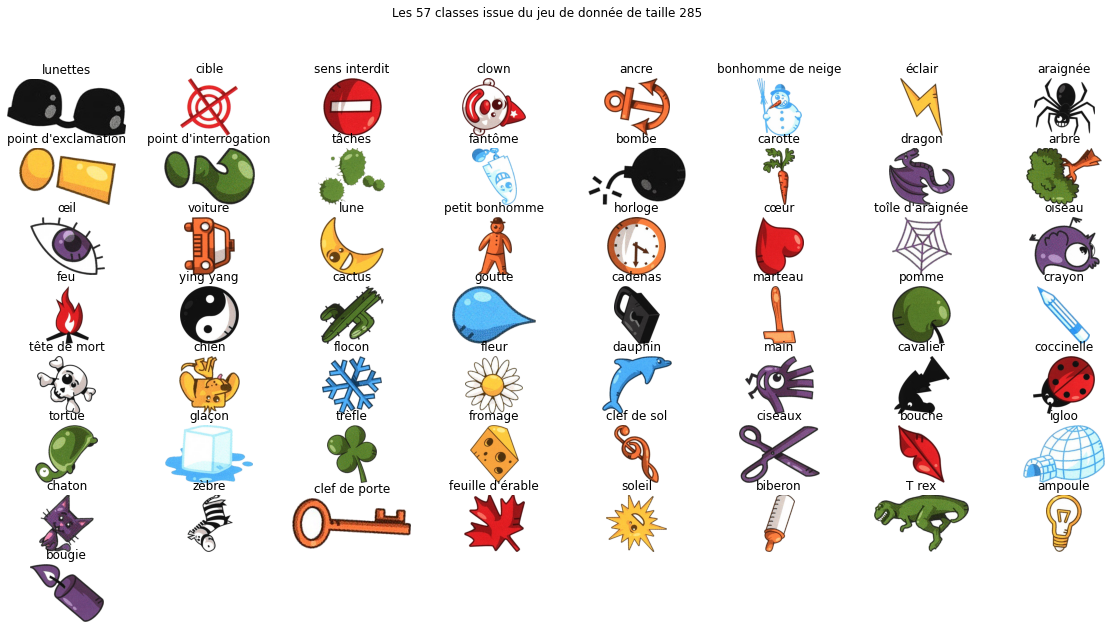

In [3]:
fig = plt.figure(figsize=(20,10))

fig.suptitle(f"Les {len(df.category.unique())} classes issue du jeu de donnée de taille {len(df)}")

for i in range(1, len(label_to_category) + 1):
    plt.subplot(8, 8, i)
    plt.title(label_to_category[i])
    idx = np.where(np.array(labels) == i)[0][0]
    plt.imshow(dataset[idx])
    plt.axis('off')

plt.show()

- They also seem to have different shapes with:
    - `(71, 80)` being the smallest shape
    - `(199.7, 194.5)` being the mean shape
    - `(398, 418)` being the biggest shape
- Is it useful to reshape all images to the same shape?

In [4]:
df.describe()

,label,width,height
count,285.000000,285.000000,285.000000
mean,29.000000,199.691228,194.575439
std,16.480889,59.894944,56.456877
min,1.000000,71.000000,80.000000
25%,15.000000,157.000000,155.000000
50%,29.000000,195.000000,192.000000
75%,43.000000,236.000000,225.000000
max,57.000000,398.000000,418.000000


We also noticed that only 5 samples are presented per class, which may indicate that data augmentation may be an interesting avenue to explore. 

In [5]:
df.groupby("category").count()["label"]

category
T rex                    5
ampoule                  5
ancre                    5
araignée                 5
arbre                    5
biberon                  5
bombe                    5
bonhomme de neige        5
bouche                   5
bougie                   5
cactus                   5
cadenas                  5
carotte                  5
cavalier                 5
chaton                   5
chien                    5
cible                    5
ciseaux                  5
clef de porte            5
clef de sol              5
clown                    5
coccinelle               5
crayon                   5
cœur                     5
dauphin                  5
dragon                   5
fantôme                  5
feu                      5
feuille d'érable         5
fleur                    5
flocon                   5
fromage                  5
glaçon                   5
goutte                   5
horloge                  5
igloo                    5
lune               

That is why we decided to implement simple data augmentation techniques such as rotation and resize.

In [6]:
tmp_dataset_aug, tmp_labels_aug = dataset_augmentation([dataset[3]], [labels[3]], transformation_per_image=1)

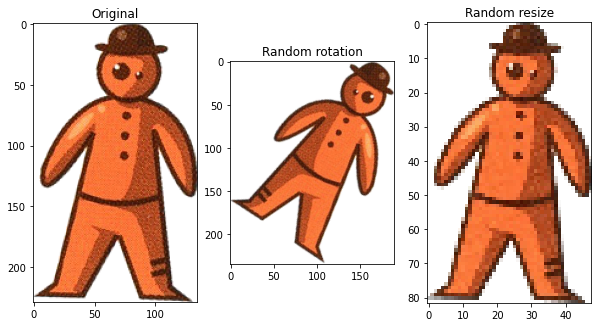

In [7]:
# Different colors + rotation are performed
plt.figure(figsize=(10,10))

plt.subplot(1, 3, 1)
plt.imshow(tmp_dataset_aug[0])
plt.title("Original")
plt.subplot(1, 3, 2)
plt.title("Random rotation")
plt.imshow(tmp_dataset_aug[1])
plt.subplot(1, 3, 3)
plt.title("Random resize")
plt.imshow(tmp_dataset_aug[2])

plt.show()

We also decided to split our dataset into a training and validation set in a stratified way such that the validation set properly represented the training set. 

In [8]:
from sklearn.model_selection import train_test_split

print(f"Original dataset = {len(dataset)}")
img_train, img_test, label_train, label_test = train_test_split(dataset, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)
print(f"Train size = {len(img_train)}")
img_train_aug, label_train_aug = dataset_augmentation(img_train, label_train, transformation_per_image=1)
print(f"Train size augmented = {len(img_train_aug)}")

Original dataset = 285
Train size = 228
Train size augmented = 684


# II/ Feature extraction <a class="anchor" id="feature-extraction"></a>

To make our pipeline work, we need to transform raw image data into numerical features that can be processed by a classifier. Since our dataset contains image that have different size, rotation and noise, those features need to be invariant to those transformation and keep a low dimensionality to be fast enough to process.

We will split this feature extraction step in two parts: color extraction & shape extraction.

### A) Color extraction <a class="anchor" id="color-extraction"></a>

In this step, we will try to express our image as an histogram of common colors we see in our dataset. To do this, we need to indentify those colors.

In our dataset, images are surrounded by a white background. Since the proportion of this background vary with the rotation of the image, we need to eliminate it as it may bias our color extraction. For this, we will create a mask for each image.

In [9]:
def create_mask(img):
    selector = (img[...,0] == 255) & (img[...,1] == 255) & (img[...,2] == 255)
    return ~selector

mask_train = [create_mask(img) for img in img_train]

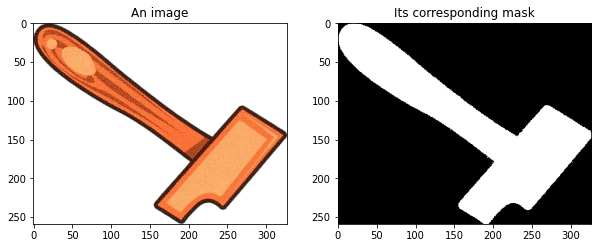

In [10]:
# Plot img & its corresponding mask
fx, plots = plt.subplots(1, 2, figsize=(10,5))
plots[0].set_title("An image")
plots[0].imshow(img_train[0])
plots[1].set_title("Its corresponding mask")
plots[1].imshow(mask_train[0], cmap='gray')
plt.show()

#### 1 - Creating a color palette <a class="anchor" id="color-palette"></a>

To create a color palette we will first extract samples of pixels from each image, and aggregate them in what we call a "super sample".

In [11]:
samples = []
for (i, img) in enumerate(img_train):
    img_masked = img[mask_train[i]]
    indices = np.random.choice(img_masked.shape[0], 50, replace=False)
    sample = img_masked[indices]

    samples.append(sample)

super_sample = np.vstack(samples)

Unique colors: 8692


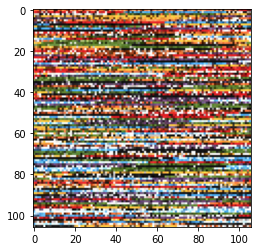

In [12]:
# Display super sample
from math import sqrt
side = int(sqrt(float(super_sample.shape[0])))
plt.imshow(super_sample[:(side * side)].reshape((side, side, 3)))

# Count unique colors
print(f'Unique colors: {np.unique(super_sample, axis=0).shape[0]}')

As you can see, our super sample contains a lot of different colors. If we were to express our color features using all these colors, the dimensionality would be way too high. To reduce this set, we will quantize the super sample using the K-mean algorithm.

In [13]:
from sklearn.cluster import KMeans

kmean_color = KMeans(n_clusters=24, random_state=RANDOM_SEED)
kmean_color.fit(super_sample)
color_lut = np.uint8(kmean_color.cluster_centers_)

To find a good color palette, we need to determine a good amount a colors. Let's compare them.

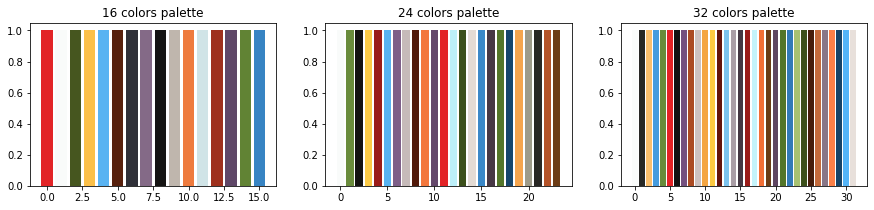

In [14]:
# Plot img & its corresponding mask
fx, plots = plt.subplots(1, 3, figsize=(15,3))

for i, count in enumerate([16, 24, 32]):
    kmean = KMeans(n_clusters=count, random_state=RANDOM_SEED)
    kmean.fit(super_sample)
    lut = np.uint8(kmean.cluster_centers_)

    plots[i].set_title(f"{count} colors palette")
    plots[i].bar(np.arange(len(lut)), np.ones(len(lut)), color=lut/255)
plt.show()

As you can see, in the 32 colors palette, some colors a repeated and some are missing in the 16 colors palette. The 24 colors palette seems to be a good fit.

#### 2 - Extracting color features using our palette <a class="anchor" id="extract"></a>

Now that our palette is created, we will use it to reconstruct our image.

In [15]:
label_maps = []
for img, mask in zip(img_train, mask_train):
    lm = kmean_color.predict(img[mask])
    label_maps.append(lm)

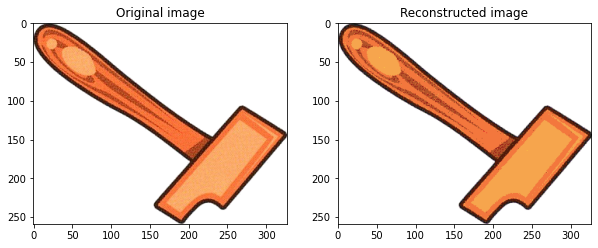

In [16]:
recolored_img = np.ones(img_train[0].shape, dtype=np.uint8) * 255
recolored_img[mask_train[0]] = color_lut[label_maps[0]]

fx, plots = plt.subplots(1, 2, figsize=(10,5))
plots[0].set_title("Original image")
plots[0].imshow(img_train[0])
plots[1].set_title("Reconstructed image")
plots[1].imshow(recolored_img)
plt.show()

As you can see, the reconstructed image is very similar to our original image. Let's now build an histogram using our palette.

In [17]:
# Extract histogram (use minlength to ensure homogeneous dimensionality)
histograms = np.array([np.bincount(lm, minlength=len(
        kmean_color.cluster_centers_)) / len(lm) for lm in label_maps], dtype=np.float64)

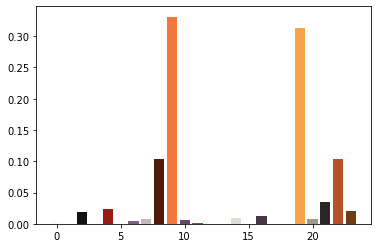

In [18]:
plt.bar(np.arange(len(color_lut)), 
         histograms[0], 
         color=color_lut/255)
plt.show()

The color histogram is now ready, we can use it to describe the color features of our image.

### B) Shape extraction <a class="anchor" id="shape-extraction"></a>

We now have an descriptor that can extract the colors of an image. We will now try to extract informations about the shape. 

For this purpose, we will try to use two different shape extraction technique, the first one using Hu Moments, and the second using ORB algorithm.

#### 1 - Hu Moments <a class="anchor" id="hu-moments"></a>

Hu Moments are a set of 7 numbers calculated using central moments that are invariant to image transformations. They are normally extracted from the silhouette or outline of an object in an image. Will try to compute a clean and normalized outline of an image.

First, we will remove the color of our image.

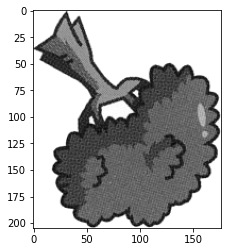

In [19]:
import cv2

gray_img = cv2.cvtColor(img_train[5], cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.show()

To compute the outline of an image we will use this pipeline:
- Add borders and padding to ensure the image is square, and not too close from the edges
- Blur the image, to remove any noise
- Binarize the image using Otsu thresholding
- Compute the contour using Canny algorithm

You can see the different steps below.

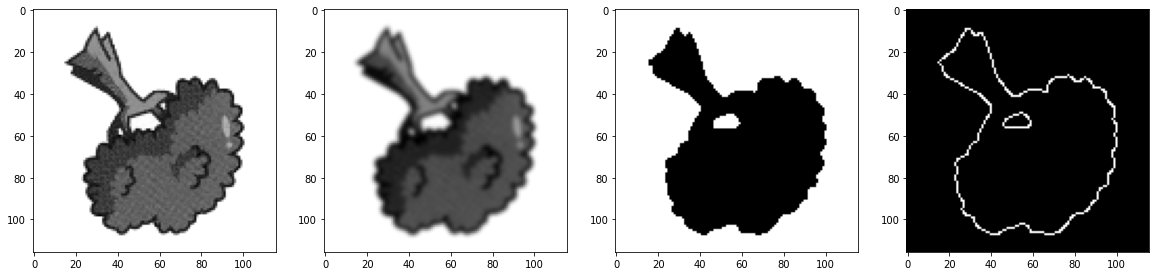

In [20]:
height, width = gray_img.shape
if height > width:
    square_img = cv2.copyMakeBorder(gray_img, 0, 0, (height - width) // 2, (height - width) // 2, cv2.BORDER_CONSTANT, value=255)
elif width > height:
    square_img = cv2.copyMakeBorder(gray_img, (width - height) // 2, (width - height) // 2, 0, 0,  cv2.BORDER_CONSTANT, value=255)

resized_img = cv2.resize(square_img, (100, 100))
padded_img = cv2.copyMakeBorder(resized_img, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=255)

fx, plots = plt.subplots(1, 4, figsize=(20,5))

plots[0].imshow(padded_img, cmap='gray')

blurred_img = cv2.GaussianBlur(padded_img, (5, 5), 0)
plots[1].imshow(blurred_img, cmap='gray')

_, binary_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plots[2].imshow(binary_img, cmap='gray')

canny_img = cv2.Canny(binary_img, 100, 200)
plots[3].imshow(canny_img, cmap='gray')

plt.show()

We can now compute Hu Moments of our outline using OpenCV.

In [21]:
moments = cv2.moments(canny_img)
hu_moments = cv2.HuMoments(moments).flatten()
hu_moments

array([ 1.55150504e-02,  1.22243388e-05,  4.78557538e-07,  4.74015942e-08,
       -3.51614433e-15,  1.51332093e-10,  6.21341595e-15])

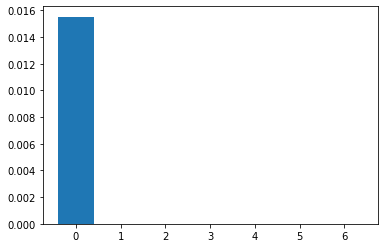

In [22]:
plt.bar(np.arange(len(hu_moments)), hu_moments)
plt.show()

As you can see, if we plot our moments, one of the feature stands out and is much higher than the others in comparision. Let's apply logarithmic scale to fix this.

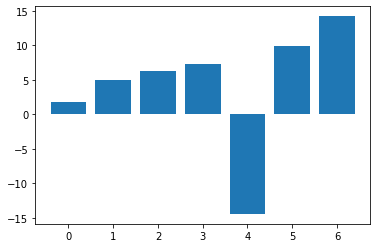

In [23]:
hu_moments_log = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
plt.bar(np.arange(len(hu_moments_log)), hu_moments_log)
plt.show()

The moments descriptor is now ready, we can use it to describe the shape of our image.

#### 2 - ORB <a class="anchor" id="orb"></a>

- Even it falls out of scope of this project, we decided to still include it. 
- To extract shape feature, we can use the **Oriented FAST and Rotated BRIEF (ORB)** which is basically a fusion of:
    - **FAST** (Features from Accelerated Segment Test) for keypoints detector => **Scale invariant**
    - **rBRIEF** (Rotation-aware Binary Robust Independent Elementary Features) for descriptors computation => **Rotation invariant**
- On top of being open-source, ORB is said to be faster than its counterparts SIFT and SURF

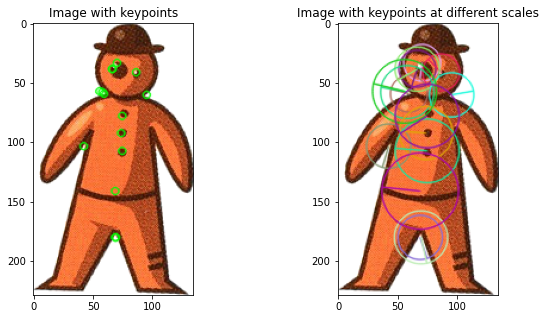

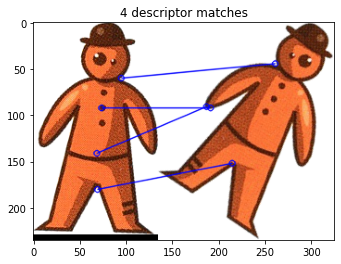

In [24]:
original = tmp_dataset_aug[0]
rotated = tmp_dataset_aug[1] 

orb = cv2.ORB_create(nfeatures=20, scaleFactor=1.2)

# Detect keypoints of original image
(kp1,des1) = orb.detectAndCompute(original, None)

# Display keypoints with/without size & orientation
kp1_without_size = np.copy(original)
kp1_with_size = np.copy(original)
cv2.drawKeypoints(original, kp1, kp1_without_size, color = (0, 255, 0))
cv2.drawKeypoints(original, kp1, kp1_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(10,5))
plots[0].set_title("Image with keypoints")
plots[0].imshow(kp1_without_size, cmap='gray')
plots[1].set_title("Image with keypoints at different scales")
plots[1].imshow(kp1_with_size, cmap='gray')

# Detect keypoints of rotated image
(kp2,des2) = orb.detectAndCompute(rotated, None)

# Create matcher to show that descriptors are properly computed
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
bf.add([des1,des2])
matches = bf.match(des1,des2)

def draw_matches(img1, kpts1, img2, kpts2, matches, color=(0,0,255), title=""):
    '''img1 and img2 are color images.'''
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]),
                           img1.shape[1]+img2.shape[1], 
                           3), 
                           dtype=np.uint8)
    img_matches = cv2.drawMatches(img1, kpts1, img2, kpts2, 
                          matches, 
                          img_matches,
                          matchColor=color,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12,4))
    plt.imshow(img_matches)
    print(title)
    plt.title(title + "%d descriptor matches" % (len(matches),))

draw_matches(original, kp1, rotated, kp2, matches)

# III/ Model creation <a class="anchor" id="model-creation"></a>

We remind that the given dataset is made of 285 images of 57 different classes of Dobble symbols. Therefore, we can note that the dataset has the following characteristics:
- It has more than 2 classes (multi-class classification)
- It is discrete
- It is small (285 images, 57 classes)
- It is labelled
- It is noise-free/clean (no wrong labels)
- It is balanced (around 5 images each class)

## A) Classifier used <a class="anchor" id="classifier-used"></a>

- Dummy Classifier
- Linear Classifiers
    * Linear SVM
- Non-linear Classifiers
    * SVM: polynomial, RBF
    * KNearest-Neighbor with `euclidean` and `cosine` distance
    * Decision Tree
    * Random Forest
    
## B) Reasons Behind Selection <a class="anchor" id="reason"></a>

- We used the `Dummy` classifier as a pipeline sanity check and a reference of minimal success to others (1 / number_of_classes = 1 / 57).
- Now, when it comes to useful classifiers, we needed one that is known to work well with image recognition but we were open for other options.
- We also had to take a closer look at the properties of our current dataset in order to find the right matches. 
- *We could not tell if the descriptors could be linearly separated or not so we tested both types of classifiers.*
- `SVM` classifiers are often used for image recognition challenges. The algorithm is good for small and clean datasets, can output very accurate results and is useful for both linearly separable data and non–linearly separable data.
- `K-NN` or `KNearest-Neighbor` classifiers are best used when we have:
    - Labelled dataset.
    - On a small dataset, because the classifier completes execution in a shorter time period.
    - Noise-free data.
which is exactly our case.
- `Decision Trees` are a great fit for discrete variables and balanced datasets and can handle various data types if needed.
- `Random forest` classifiers are less famous in image recognition but knowing that we will be using multiple feature extractors, it is well suited for determining feature importance and reducing the risk of overfitting on our small train set.
---

**They all matched more or less what we needed. Thus, we decided to test them all and find the most adapted one by evaluating them with our selected metrics**.

> - sources: 
>   - https://explore.mathworks.com/common-machine-learning-challenges
>   - https://www.ibm.com/cloud/learn/random-forest
>   - https://www.aitude.com/svm-difference-between-linear-and-non-linear-models/
>   -  https://www.aitude.com/basics-of-k-nearest-neighbor-algorithm/


# IV/ Model evaluation <a class="anchor" id="model-evaluation"></a>

- To evaluate our model, we decided to choose accuracy as a metric
- Confusion matrix were plotted to diagnostic our classifiers

In [25]:
%cd app/

from app.main import load_dataset, train_test_split, dataset_augmentation, feature_extractor, LOAD_SESSION, RANDOM_SEED, PONDERATION
from app.fusion import train, evaluate
from app.visualization import plot_confusion_matrix
import numpy as np

%cd ..

/home/bouteille/Documents/iml-project/app
/home/bouteille/Documents/iml-project


In [26]:
print('Loading dataset...')
dataset, labels = load_dataset("./dataset/train")

img_train, img_test, label_train, label_test = train_test_split(
    dataset, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)

print("Create feature extractor ...\n")
color_feature_extractor, shape_feature_extractor = feature_extractor(
    img_train, load_session=LOAD_SESSION, mode="moments")

Loading dataset...
Create feature extractor ...

Mode Hu moments ...


## A) Dummy classifier <a class="anchor" id="dummy-classifier"></a>

To sanity check our pipeline, we trained a dummy classifier. It should predict 1/57 = 0.0175438596

In [27]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier() 
train(clf, color_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, color_feature_extractor(img_test), label_test)
print(accuracy)

0.017543859649122806


Since there are 57 classes, we cannot afford to plot a single confusion matrix. Thus, what we did was to plot one class against all the others.

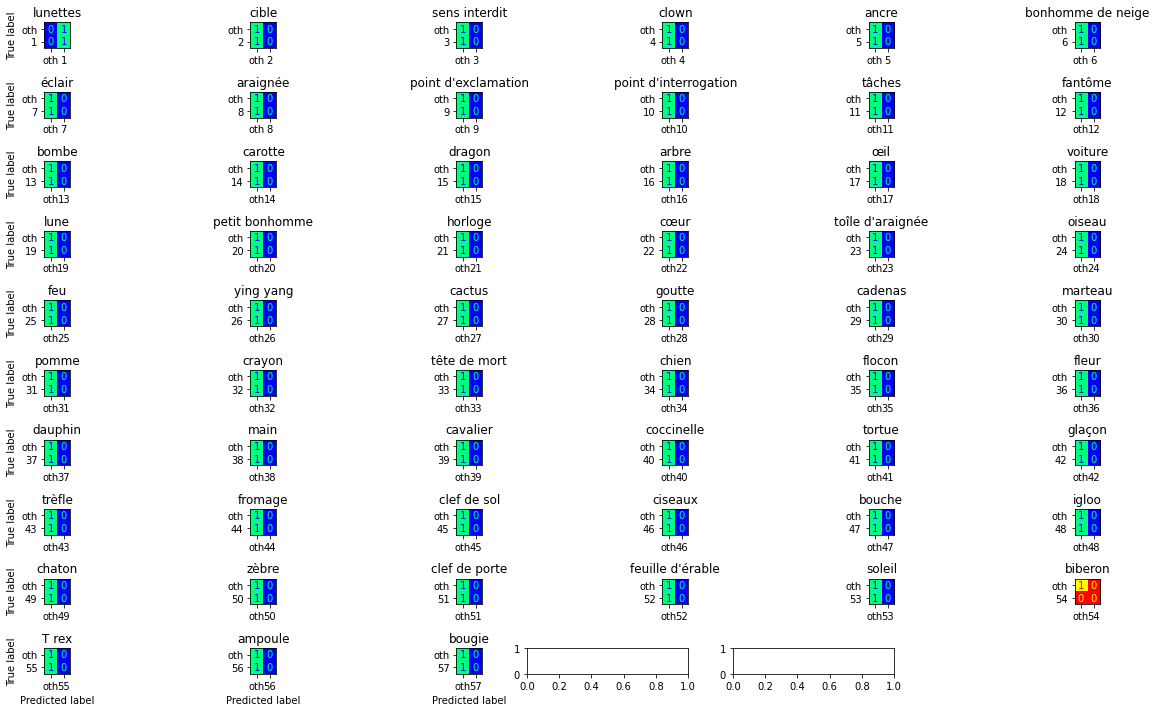

In [28]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

## B) Train Color descriptor (alone) <a class="anchor" id="color-descriptor"></a>

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5)

In [30]:
train(clf, color_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, color_feature_extractor(img_test), label_test)
print(accuracy)

0.9824561403508771


- From the confusion matrix, let's take the **top-left grid** labelled `lunettes` and see what we can infer from it:
    - **True positive** (top-left square): It predicts it was `lunette` and it was indeed a `lunette`.
    - **True negative** (bottom-right square): It says it wasn't a lunette and it was indeed a lunette
- It seems like the color extractor alone has trouble with the following class: `araignée`, `trèfle`, `clef de porte` and `biberon`

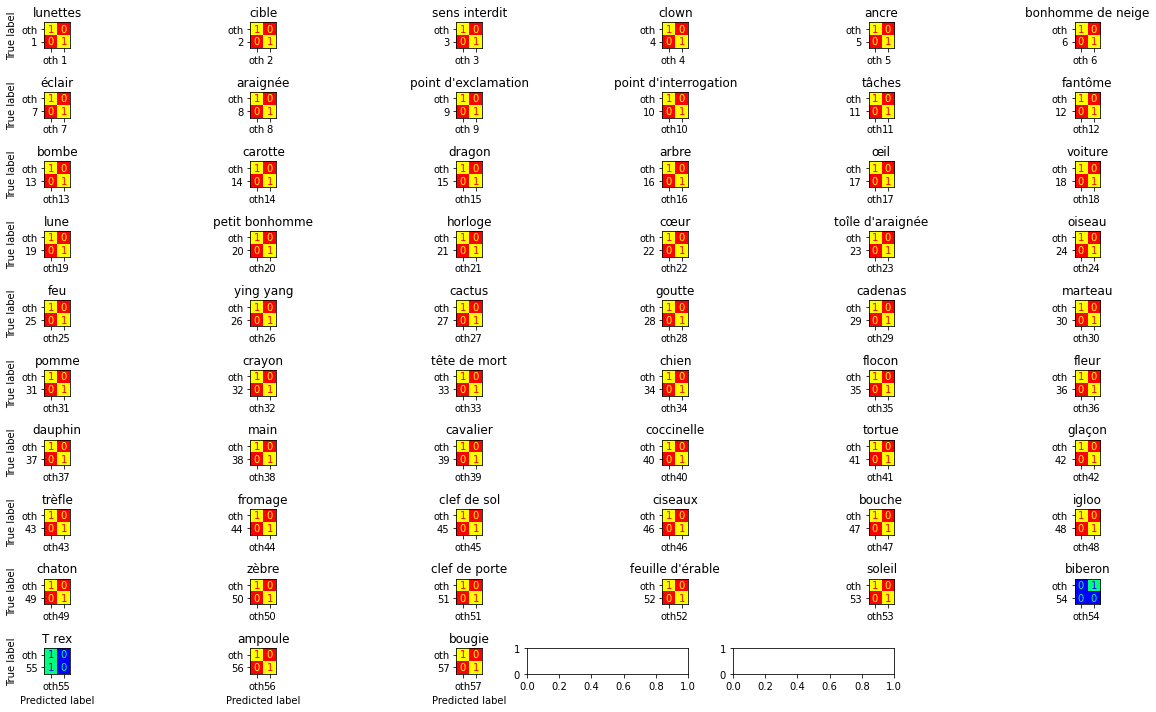

In [31]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

## C) Train Shape descriptor <a class="anchor" id="shape-descriptor"></a>

### 1 - Hu moments (alone) <a class="anchor" id="hu-moment-alone"></a>

In [32]:
clf = RandomForestClassifier(max_depth=5)
_, shape_feature_extractor = feature_extractor(img_train_aug, load_session=LOAD_SESSION, mode="moments")

Mode Hu moments ...


In [33]:
train(clf, shape_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, shape_feature_extractor(img_test), label_test)
print(accuracy)

0.9298245614035088


It seems like the shape extractor alone has trouble with the following class: `cavalier` and `biberon`

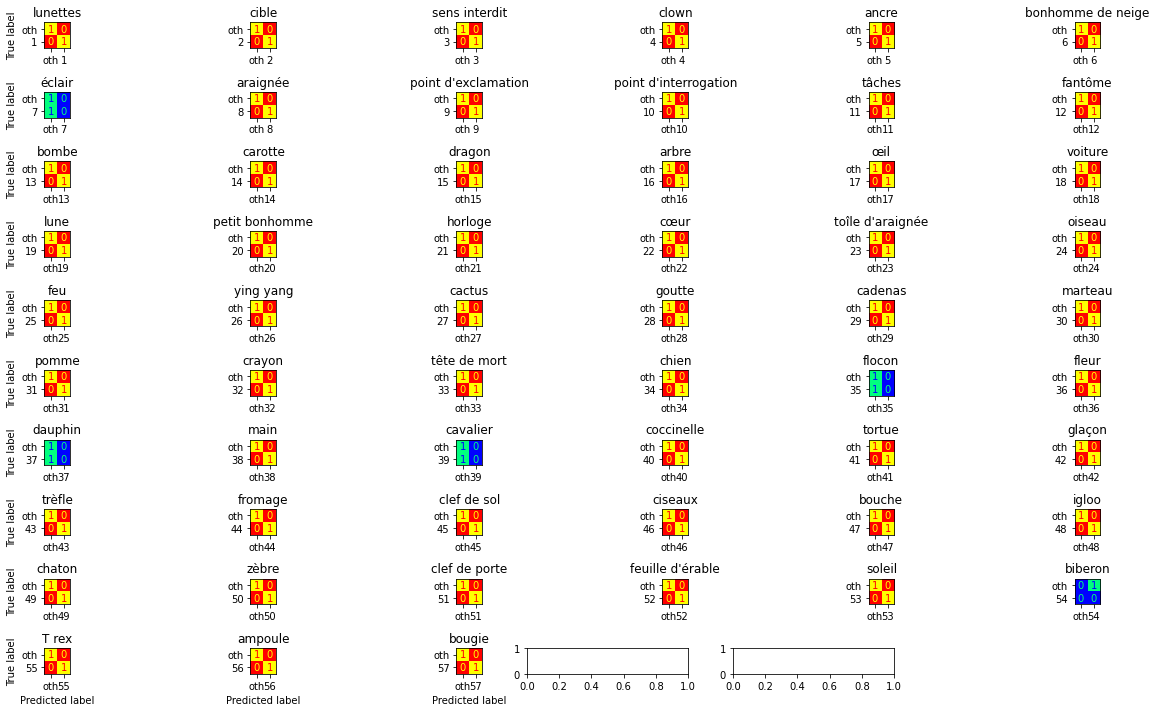

In [34]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

### 2 - ORB (alone) <a class="anchor" id="orb-alone"></a>

We didn't investigate ORB enough as it falls out of this project scope but still decided to evaluate (results are not guaranteed to be good). 

In [35]:
clf = RandomForestClassifier(max_depth=8)
_, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="orb")

Mode ORB ...


In [36]:
train(clf, shape_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, shape_feature_extractor(img_test), label_test)
print(accuracy)

0.7192982456140351


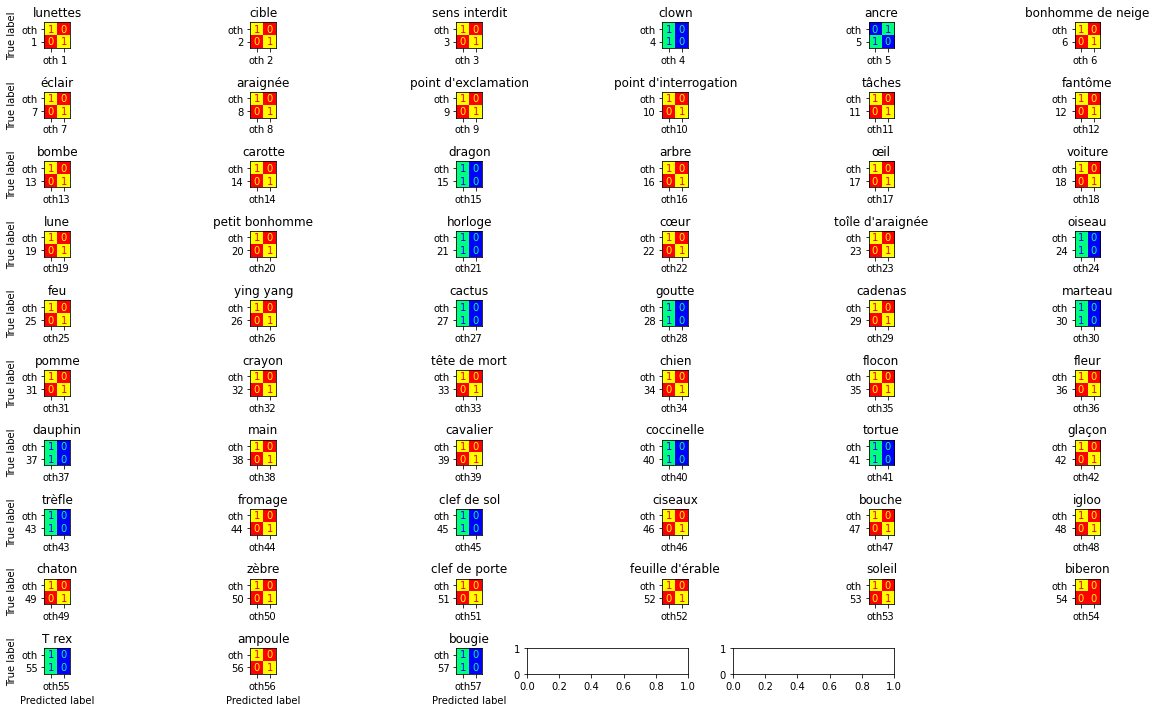

In [37]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

## D) Train color descriptor + Shape descriptor (Hu moment) <a class="anchor" id="combined"></a>

- We now evaluate the color and shape descriptor (Hu moment) all together in two ways:
    - **Early fusion**: we concatenated the color and shape descriptor before feeding it to a classifier
    - **Late fusion**: we feed the color and shape descriptors separately to 2 classifiers and make for example a vote, to aggregate the results

### 1 - Early fusion <a class="anchor" id="early"></a>

In [38]:
clf = RandomForestClassifier(max_depth=5)

In [39]:
color_feature_extractor, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="moments")

def feature_extractor_fusion(color_feature_extractor, shape_feature_extractor):
    return lambda img: np.hstack((color_feature_extractor(img) * PONDERATION, shape_feature_extractor(img) * (1 - PONDERATION)))

fused_feature_extractor = feature_extractor_fusion(color_feature_extractor, shape_feature_extractor)

feature_train = fused_feature_extractor(img_train)
feature_test = fused_feature_extractor(img_test)

Mode Hu moments ...


In [40]:
train(clf, feature_train, label_train)
prediction, accuracy = evaluate(clf, feature_test, label_test)
print(accuracy)

0.9649122807017544


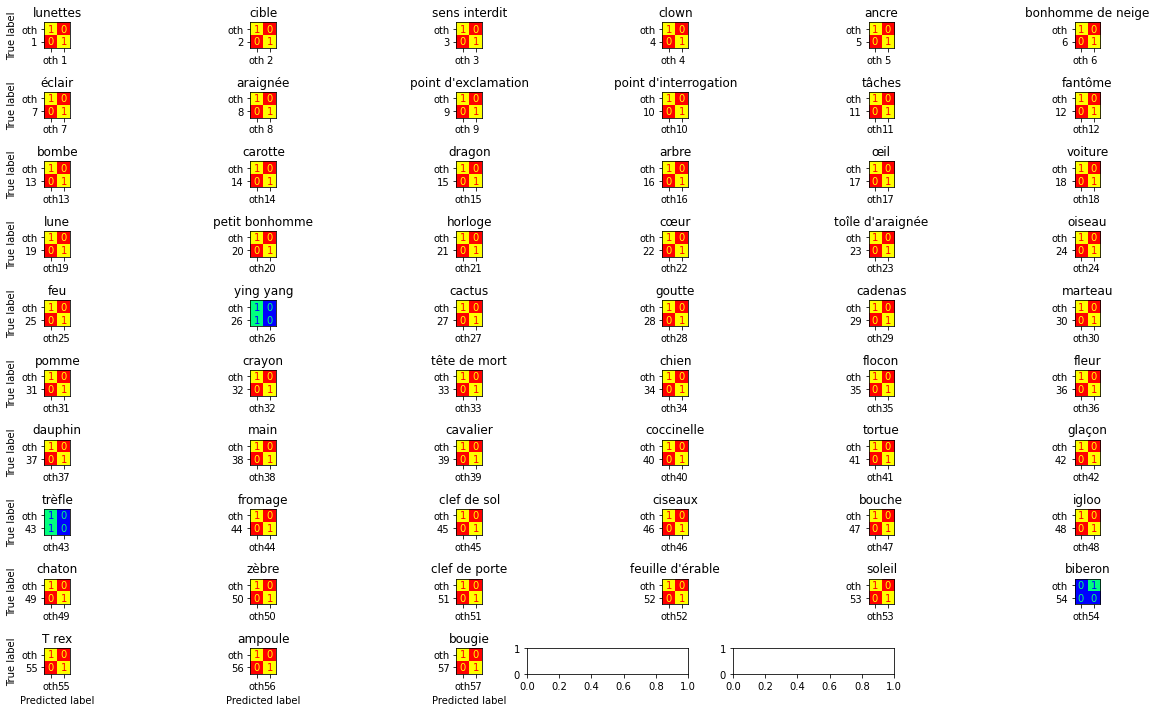

In [41]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

### 2 - Late fusion <a class="anchor" id="late"></a>

In [42]:
clf_0 = RandomForestClassifier(max_depth=3)
clf_1 = RandomForestClassifier(max_depth=5)

In [43]:
color_feature_train = color_feature_extractor(img_train)
shape_feature_train = shape_feature_extractor(img_train)

color_feature_test = color_feature_extractor(img_test)
shape_feature_test = shape_feature_extractor(img_test)

train(clf_0, color_feature_train, label_train)
train(clf_1, shape_feature_train, label_train)

In [44]:
def soft_voting(color_predict_proba, shape_predict_proba):
    def get_max_proba_indices(color_predict_proba, shape_predict_proba):
        classes_pred_proba = 0.6 * color_predict_proba + 0.4 * shape_predict_proba
        return np.argmax(classes_pred_proba, axis=1)

    max_proba_indices = get_max_proba_indices(
        color_predict_proba, shape_predict_proba)
    
    return max_proba_indices + 1


color_labels = clf_0.predict(color_feature_test)
shape_labels = clf_1.predict(shape_feature_test)

prediction = soft_voting(clf_0.predict_proba(color_feature_test), clf_1.predict_proba(shape_feature_test))
accuracy = np.sum(np.array(prediction) ==np.array(label_test)) / len(prediction)
print(accuracy)

0.9824561403508771


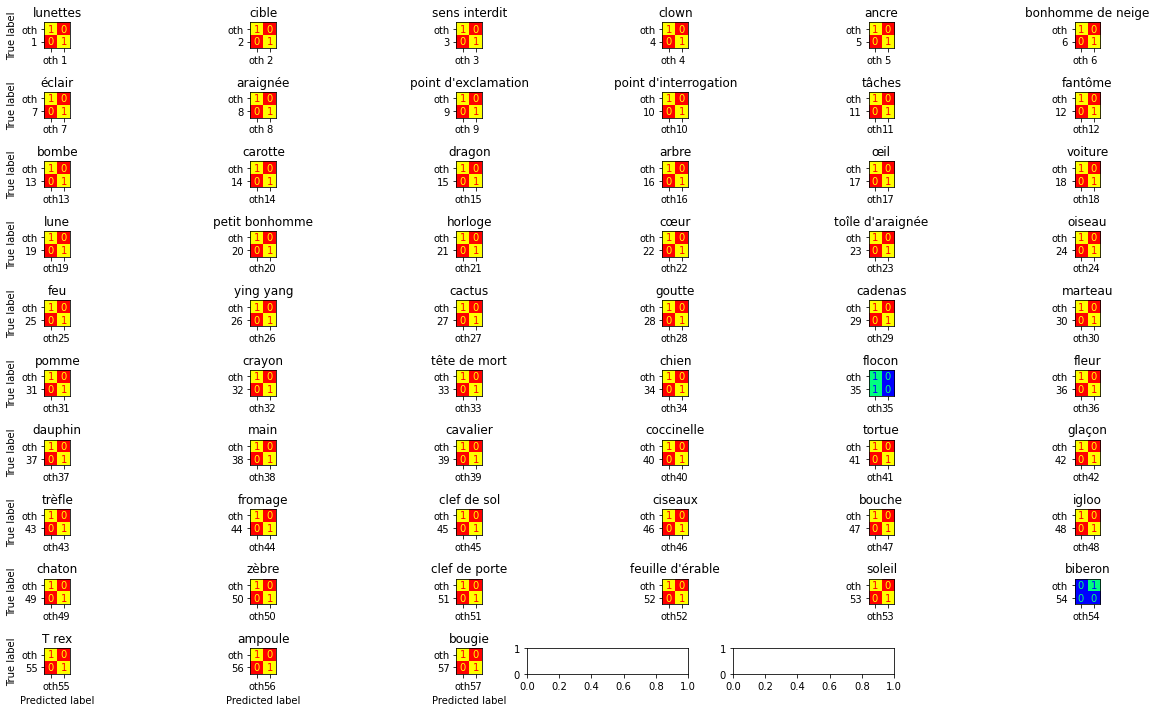

In [45]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

# V/ Model benchmark <a class="anchor" id="model-benchmark"></a>

We will establish a benchmark by comparing accuracy of color descriptor and shape descriptor combined (Hu-moments) over:
   - different data augmentation
   - different fusion (early, late, stacking-early and stacking-late)

## A) Benchmark <a class="anchor" id="benchmark"></a>

|                 | Type de fusions | Classifiers utilisés          | Temps d'execution (s) | Meilleur accuracy (%) | Autres accuracy (%) |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 26,403                | 100                   | 95,41               |
|                 |                 | SVM linear                    |                       |                       | 98,83               |
|                 |                 | SVM poly                      |                       |                       | 31,50               |
|                 |                 | SVM rbf                       |                       |                       | 12,30               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 99,75               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 10  | Late            | Knn - Knn                     | 68,033                | 100                   | 100                 |
|     CV = 40     |                 | Knn - Random forest           |                       |                       | 100                 |
|                 |                 | Knn - Decision tree           |                       |                       | 99,92               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 96,41               |
|                 |                 | Random forest - Decision tree |                       |                       | 99,16               |
|                 |                 | Decision tree - Decision tree |                       |                       | 99,67               |
|                 |                 | Decision tree - Knn           |                       |                       | 99,67               |
|                 |                 | Decision tree - Random forest |                       |                       | 99,33               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 91,98                 | 100                   | 99,67               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 53,77                 | 100                   | 100                 |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 12,88                 | 100                   | 92,5                |
|                 |                 | SVM linear                    |                       |                       | 98,41               |
|                 |                 | SVM poly                      |                       |                       | 23,12               |
|                 |                 | SVM rbf                       |                       |                       | 15,16               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 99,51               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 5   | Late            | Knn - Knn                     | 33,977                | 100                   | 99,84               |
|     CV = 40     |                 | Knn - Random forest           |                       |                       | 100                 |
|                 |                 | Knn - Decision tree           |                       |                       | 100                 |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 95,06               |
|                 |                 | Random forest - Decision tree |                       |                       | 96,49               |
|                 |                 | Decision tree - Decision tree |                       |                       | 99,68               |
|                 |                 | Decision tree - Knn           |                       |                       | 99,52               |
|                 |                 | Decision tree - Random forest |                       |                       | 99,68               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 46,344                | 100                   | 99,36               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 23,348                | 99,84                 | 99,84               |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 5,185                 | 100                   | 80,7                |
|                 |                 | SVM linear                    |                       |                       | 84,21               |
|                 |                 | SVM poly                      |                       |                       | 12,28               |
|                 |                 | SVM rbf                       |                       |                       | 16,37               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 97,08               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 1   | Late            | Knn - Knn                     | 14,97                 | 100                   | 99,42               |
|     CV = 12     |                 | Knn - Random forest           |                       |                       | 99,42               |
|                 |                 | Knn - Decision tree           |                       |                       | 99,42               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 91,23               |
|                 |                 | Random forest - Decision tree |                       |                       | 94,15               |
|                 |                 | Decision tree - Decision tree |                       |                       | 98,25               |
|                 |                 | Decision tree - Knn           |                       |                       | 95,32               |
|                 |                 | Decision tree - Random forest |                       |                       | 95,91               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 10,128                | 100                   | 98,83               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 8,291                 | 100                   | 100                 |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 4,648                 | 100                   | 80,7                |
|                 |                 | SVM linear                    |                       |                       | 84,21               |
|                 |                 | SVM poly                      |                       |                       | 12,28               |
|                 |                 | SVM rbf                       |                       |                       | 16,37               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 97,08               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 1   | Late            | Knn - Knn                     | 10,124                | 100                   | 99,42               |
|     CV = 5      |                 | Knn - Random forest           |                       |                       | 99,42               |
|                 |                 | Knn - Decision tree           |                       |                       | 99,42               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 91,23               |
|                 |                 | Random forest - Decision tree |                       |                       | 94,15               |
|                 |                 | Decision tree - Decision tree |                       |                       | 98,25               |
|                 |                 | Decision tree - Knn           |                       |                       | 95,32               |
|                 |                 | Decision tree - Random forest |                       |                       | 95,91               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 6,157                 | 100                   | 98,83               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 4,354                 | 100                   | 100                 |
|-----------------|-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Early           | Knn                           | 1,657                 | 100                   | 66,67               |
|                 |                 | SVM linear                    |                       |                       | 64,91               |
|                 |                 | SVM poly                      |                       |                       | 42,11               |
|                 |                 | SVM rbf                       |                       |                       | 42,11               |
|                 |                 | Random forest                 |                       |                       | 100                 |
|                 |                 | Decision tree                 |                       |                       | 91,47               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|  Data aug = 0   | Late            | Knn - Knn                     | 5,028                 | 100                   | 94,74               |
|     CV = 4      |                 | Knn - Random forest           |                       |                       | 92,98               |
|                 |                 | Knn - Decision tree           |                       |                       | 92,98               |
|                 |                 | Random forest - Random forest |                       |                       | 100                 |
|                 |                 | Random forest - Knn           |                       |                       | 73,68               |
|                 |                 | Random forest - Decision tree |                       |                       | 80,70               |
|                 |                 | Decision tree - Decision tree |                       |                       | 87,72               |
|                 |                 | Decision tree - Knn           |                       |                       | 89,47               |
|                 |                 | Decision tree - Random forest |                       |                       | 87,72               |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking early  | Decision tree + Random forest | 2,418                 | 100                   | 87,72               |
|                 |                 | Decision tree + pipeline      |                       |                       | 100                 |
|                 |-----------------|-------------------------------|-----------------------|-----------------------|---------------------|
|                 | Stacking late   | Decision tree + Random forest | 2,081                 | 92,98                 | 92,98               |

## B) Interpretation <a class="anchor" id="interpretation"></a>

- Except the execution time, the cross-validation (CV) doesn't seem to have much influence on the results, when there isn't much data augmentation. But the less data we have, the less accuracy different models can achieve.
- However the Random forest classifier always has the highest score, it reaches 100% accuracy whether there is data augmentation or not.
- Therefore, since early fusion takes the least time to run, it seems to be the best method in our case.
-  So, it doesn't seem to be necessary to apply data augmentation.
- Even if the lack of data augmentation does not lower the best accuracy, this is due to the low number of tests. If the same test is run several times, it can lead to a less accurate result. 
- But the more data we have trained our model on, the more likely it is that we will get a better result.
- Thus we decide to use a data augmentation of 20 for our final submission.